In [1]:
import os
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import to_categorical

from deepcell.utils.plot_utils import create_rgb_image
from deepcell.datasets import SpotNetExampleData, SpotNet
from deepcell_spots.applications import SpotDetection
from deepcell_spots.dotnet_losses import DotNetLosses

from deepcell_spots.utils.augmentation_utils import subpixel_distance_transform

from deepcell_spots.image_generators import ImageFullyConvDotIterator

import example_bank

from dotenv import load_dotenv

load_dotenv()

2025-01-07 20:34:46.129865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-07 20:34:46.129933: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/jonathan/deepcell-spots-llm/venv/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


True

In [2]:
spots_data = np.load('spot_data/SpotNet-v1_1/test.npz', allow_pickle=True)
spots_images = spots_data['X']
spots_truth = spots_data['y']

In [3]:
spots_image = spots_images
spots_truth = spots_truth
spots_image.shape

(94, 128, 128, 1)

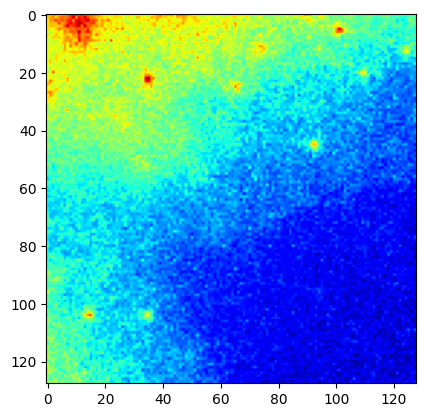

In [4]:
plt.imshow(spots_image[0].squeeze(), cmap='jet')

In [5]:
app = SpotDetection(preprocessing_fn=example_bank.contrast_stretch)

INFO:root:Checking for cached data
INFO:root:Checking SpotDetection-8.tar.gz against provided file_hash...
INFO:root:SpotDetection-8.tar.gz with hash a6164e48ef8872a9524b4ec6726859d7 already available.
INFO:root:Extracting /home/jonathan/.deepcell/models/SpotDetection-8.tar.gz
INFO:root:Successfully extracted /home/jonathan/.deepcell/models/SpotDetection-8.tar.gz into /home/jonathan/.deepcell/models
2025-01-07 20:34:54.195592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-07 20:34:54.196420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jonathan/deepcell-spots-llm/venv/lib/python3.10/site-packages/cv2/../../lib64:
2025-01-07 20:34:54.196513: W tensorflo

In [6]:
pred, class_output, regress_output = app.predict(spots_image, batch_size=spots_images.shape[0], threshold=0.95)

pred.shape

2025-01-07 20:34:58.215000: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 788529152 exceeds 10% of free system memory.
2025-01-07 20:34:58.728122: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 788529152 exceeds 10% of free system memory.
2025-01-07 20:34:59.272215: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 788529152 exceeds 10% of free system memory.
2025-01-07 20:34:59.608115: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 794689536 exceeds 10% of free system memory.
2025-01-07 20:34:59.835139: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 950678400 exceeds 10% of free system memory.


(94,)

In [7]:
pred

array([array([[ 45.06906702,  92.12657289],
              [ 20.23152028, 109.16155633],
              [103.96014789,  14.16187057],
              [  5.3629986 , 100.94787291],
              [ 12.66172433, 124.07972583],
              [ 22.27122357,  34.80286697],
              [104.01780067,  34.72787416],
              [ 24.91938992,  65.31285203],
              [ 11.82155038,  73.88389695],
              [ 98.04350809,  22.78350906],
              [ 12.04169704,  93.94215173]]),
       array([[ 88.04335828,  92.05763867],
              [117.06772432,  92.92734613],
              [123.18495885,  64.05392456],
              [107.10892032,  39.20943107],
              [ 70.21804594,   7.82950883],
              [ 75.39999747,   9.13058403],
              [ 34.01973339,  33.12876171],
              [ 96.98965461,  73.22918728],
              [ 97.14167336,  26.36651492],
              [ 98.23258439,  96.28180981],
              [112.78811906,  70.47366571],
              [ 87.26010373,  

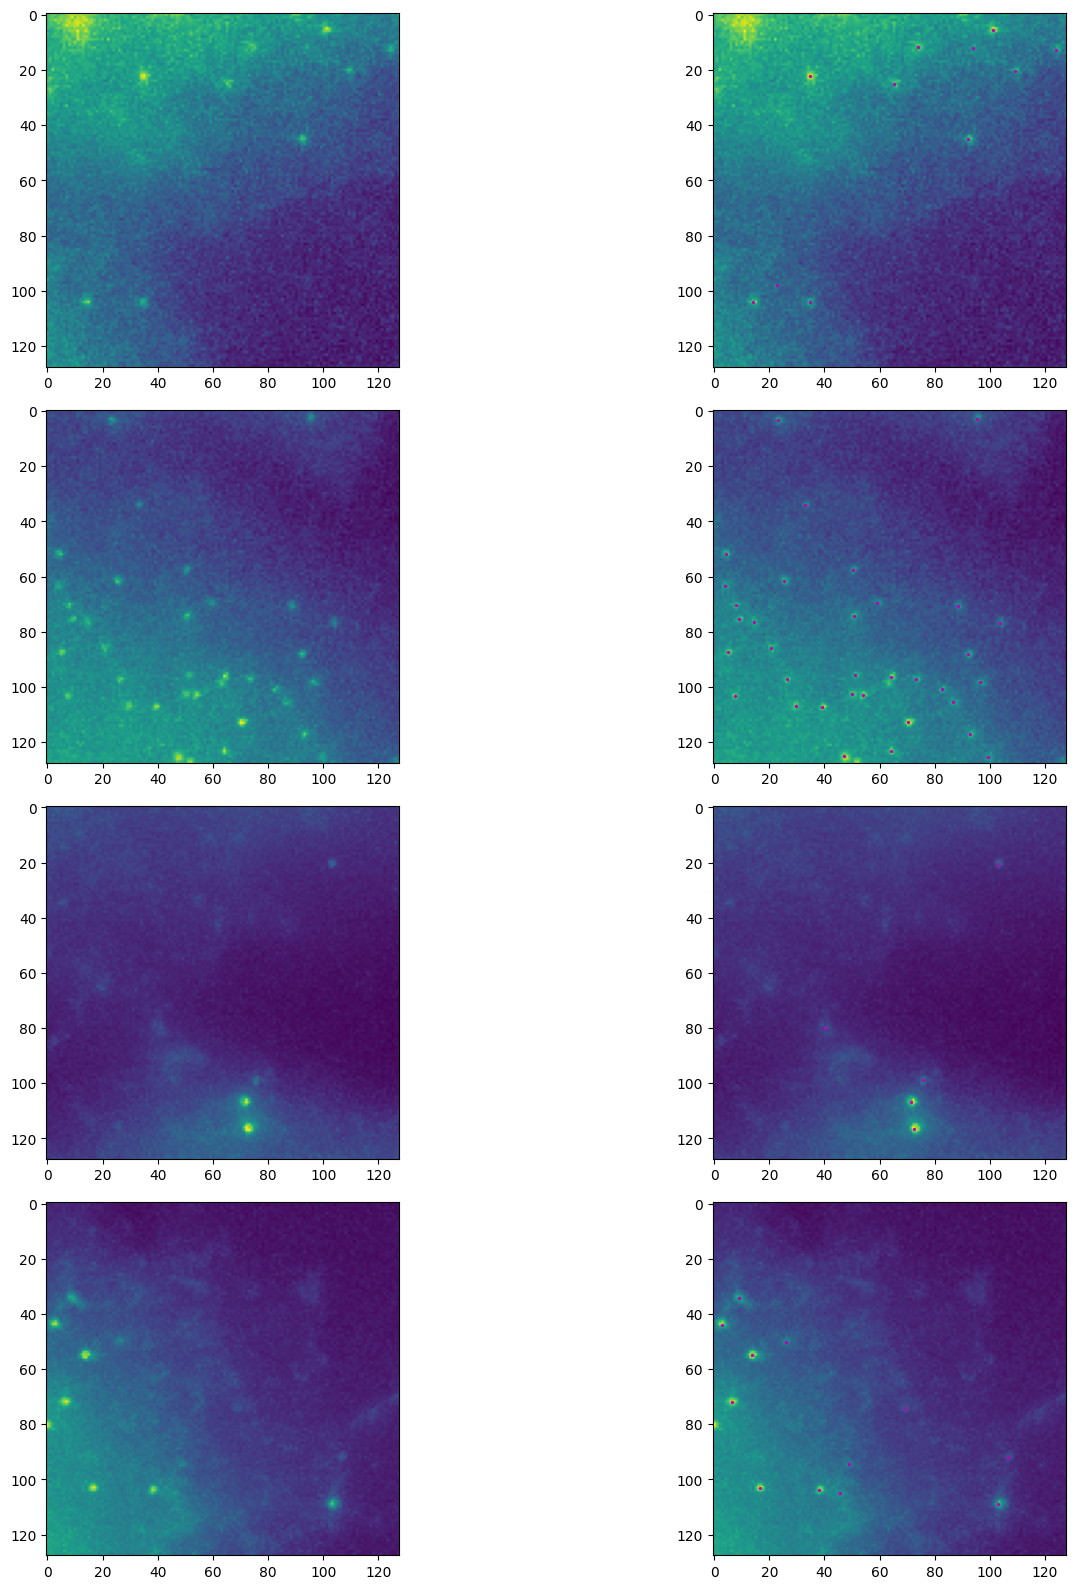

In [8]:
fig,ax = plt.subplots(4,2,figsize=(16,16))

for i in range(4):
    ax[i,0].imshow(spots_image[i,...,0], cmap='viridis')
    ax[i,1].imshow(spots_image[i,...,0], cmap='viridis')
    ax[i,1].scatter(pred[i][:,1], pred[i][:,0], c='m', s=2)


plt.tight_layout()
plt.show()

# Calculate losses

In [9]:
class_output.shape

(94, 128, 128, 2)

In [10]:
regress_output.shape

(94, 128, 128, 2)

In [11]:
def point_list_to_annotations(points, image_shape, dy=1, dx=1):
        """ Generate label images used in loss calculation from point labels.

        Args:
            points (np.array): array of size (N, 2) which contains points in the format [y, x].
            image_shape (tuple): shape of 2-dimensional image.
            dy: pixel y width.
            dx: pixel x width.

        Returns:
            annotations (dict): Dictionary with two keys, `detections` and `offset`.
                - `detections` is array of shape (image_shape,2) with pixels one hot encoding
                  spot locations.
                - `offset` is array of shape (image_shape,2) with pixel values equal to
                  signed distance to nearest spot in x- and y-directions.
        """

        contains_point = np.zeros(image_shape)
        for ind, [y, x] in enumerate(points):
            nearest_pixel_x_ind = int(round(x / dx))
            nearest_pixel_y_ind = int(round(y / dy))
            contains_point[nearest_pixel_y_ind, nearest_pixel_x_ind] = 1

        delta_y, delta_x, _ = subpixel_distance_transform(
            points, image_shape, dy=1, dx=1)
        offset = np.stack((delta_y, delta_x), axis=-1)

        one_hot_encoded_cp = to_categorical(contains_point)

        # TODO: refactor detections to classification
        annotations = {'detections': one_hot_encoded_cp, 'offset': offset}
        return annotations

In [12]:

losses = DotNetLosses()

sum_classification_loss = 0
sum_regression_loss = 0
for i in range(class_output.shape[0]):
    spot_annotations = point_list_to_annotations(spots_truth[i], spots_image.shape[1:3])
    sum_classification_loss += losses.classification_loss(spot_annotations['detections'], class_output[i]).numpy()
    sum_regression_loss += losses.regression_loss(spot_annotations['offset'], regress_output[i]).numpy()



In [13]:
sum_classification_loss / class_output.shape[0]

0.020069025687259087

In [14]:
sum_regression_loss / regress_output.shape[0]

0.30881849549552226